# Analyse statistique sur le décrochage scolaire

In [ ]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import kruskal

## Import et transformation des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Divers_etudes/'

Mounted at /content/drive


In [ ]:
#Import des data
df=pd.read_csv(file_path+"fr-en-college-effectifs-niveau-sexe-lv.csv", on_bad_lines='skip', sep=";")

# Construction de notre jeu de données
data=df[['Numéro du collège','Rentrée scolaire','Nombre d\'élèves total','Secteur','Région',
         '6èmes total','6èmes garçons','6èmes filles',
         '5èmes total','5èmes garçons','5èmes filles',
         '4èmes total','4èmes garçons','4èmes filles',
         '3èmes total','3èmes garçons','3èmes filles'
         ]]

numeric_columns = data.select_dtypes(include='number').columns

data_changed=data.groupby('Numéro du collège')[numeric_columns].mean()

for col in ['Nombre d\'élèves total','Secteur','Région']:
    data_changed[col] = data.groupby('Numéro du collège')[col].first().values

ordered_columns = ['Nombre d\'élèves total', 'Secteur','Région',
                   '6èmes total', '6èmes garçons', '6èmes filles',
                   '5èmes total', '5èmes garçons', '5èmes filles',
                   '4èmes total', '4èmes garçons', '4èmes filles',
                   '3èmes total', '3èmes garçons', '3èmes filles'
                   ]
data_changed = data_changed[ordered_columns]

data_changed['Garçons'] = data_changed['6èmes garçons'] + data_changed['5èmes garçons'] + data_changed['4èmes garçons'] + data_changed['3èmes garçons']
data_changed['Filles'] = data_changed['6èmes filles'] + data_changed['5èmes filles'] + data_changed['4èmes filles'] + data_changed['3èmes filles']

data_2019 = df[df['Rentrée scolaire'] == 2019]
data_2022 = df[df['Rentrée scolaire'] == 2022]

data_2019.rename(columns={'6èmes total': '6èmes 2019','6èmes garçons' : '6èmes garçons 2019', '6èmes filles' : '6èmes filles 2019' }, inplace=True)
data_2022.rename(columns={'3èmes total': '3èmes 2022', '3èmes garçons': '3èmes garçons 2022','3èmes filles': '3èmes filles 2022' }, inplace=True)

df_decrochage = pd.merge(data_2019, data_2022, on='Numéro du collège')
df_decrochage['decrochage'] = df_decrochage['3èmes 2022'] - df_decrochage['6èmes 2019']
df_decrochage['decrochage garçons'] = df_decrochage['3èmes garçons 2022'] - df_decrochage['6èmes garçons 2019']
df_decrochage['decrochage filles'] = df_decrochage['3èmes filles 2022'] - df_decrochage['6èmes filles 2019']

data_changed=pd.merge(data_changed,df_decrochage[['Numéro du collège','6èmes 2019','3èmes 2022','decrochage','decrochage garçons','decrochage filles']],on='Numéro du collège')




<ipython-input-4-5e4a99d1238a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019.rename(columns={'6èmes total': '6èmes 2019','6èmes garçons' : '6èmes garçons 2019', '6èmes filles' : '6èmes filles 2019' }, inplace=True)
<ipython-input-4-5e4a99d1238a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022.rename(columns={'3èmes total': '3èmes 2022', '3èmes garçons': '3èmes garçons 2022','3èmes filles': '3èmes filles 2022' }, inplace=True)


## On peut visualiser nos données

     Numéro du collège  Nombre d'élèves total Secteur  \
0             0010001W                     29  PUBLIC   
1             0010002X                    813  PUBLIC   
2             0010005A                    559  PUBLIC   
3             0010006B                     24  PUBLIC   
4             0010008D                    804  PUBLIC   
...                ...                    ...     ...   
8158          9760314M                   1419  PUBLIC   
8159          9760368W                   1475  PUBLIC   
8160          9760369X                   1814  PUBLIC   
8161          9760371Z                   1236  PUBLIC   
8162          9760379H                    674  PUBLIC   

                       Région  6èmes total  6èmes garçons  6èmes filles  \
0     AUVERGNE-ET-RHONE-ALPES         0.00           0.00          0.00   
1     AUVERGNE-ET-RHONE-ALPES       194.50         100.00         94.50   
2     AUVERGNE-ET-RHONE-ALPES       149.50          79.00         70.50   
3     AUVERGNE-

array([[<Axes: title={'center': 'decrochage'}>,
        <Axes: title={'center': "Nombre d'élèves total"}>]], dtype=object)

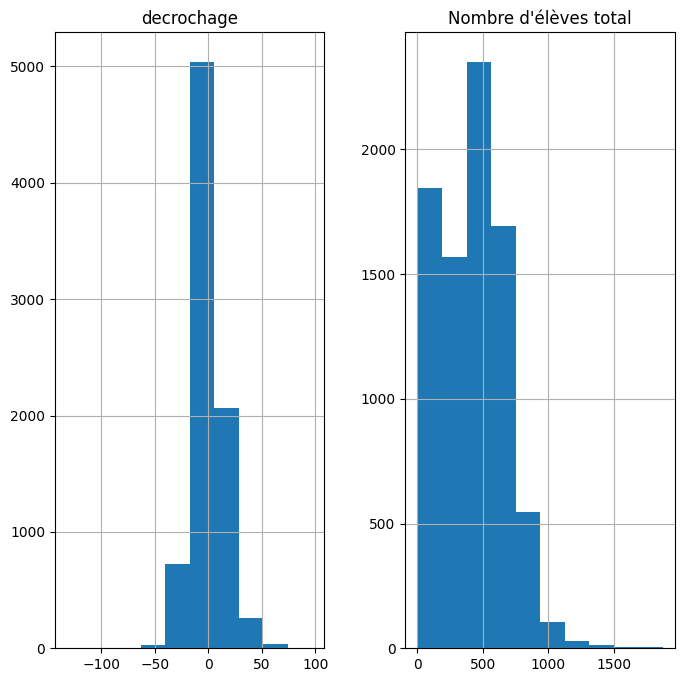

In [ ]:
#Visualisations des données
print(data_changed)
df["Rentrée scolaire"].unique() # 4 années dans nos données
data_changed.info()
data_changed.describe()
print(f"""
Il y a {round(sum(data_changed['decrochage']<0)/data_changed['decrochage'].count()*100,2)}% des collèges qui ont enregistrés du décrochage pour la cohorte d'élève étant en 6ème en 2019
""")
print(f"Il y avait {data_changed['6èmes 2019'].sum()} 6ème en 2019")
print(f"Il y avait {data_changed['3èmes 2022'].sum()} 3ème en 2022")
print(f"Il y a eu {data_changed['decrochage'].sum()} décrochages entre 2019 et 2022")
print(f"Dont {abs(data_changed['decrochage garçons'].sum())} décrochage de garçons")
print(f"Dont -{data_changed['decrochage filles'].sum()} décrochage de filles") # augmentation du nombre de filles

columns_to_plot = ['decrochage', 'Nombre d\'élèves total']
data_changed[columns_to_plot].hist(figsize=(8,8))

## Question 1 : Certains collèges ont t'ils davantage de décrochages scolaire que d'autres ?
(réduction
du nombre d'élèves entre la 6e et la 3e)


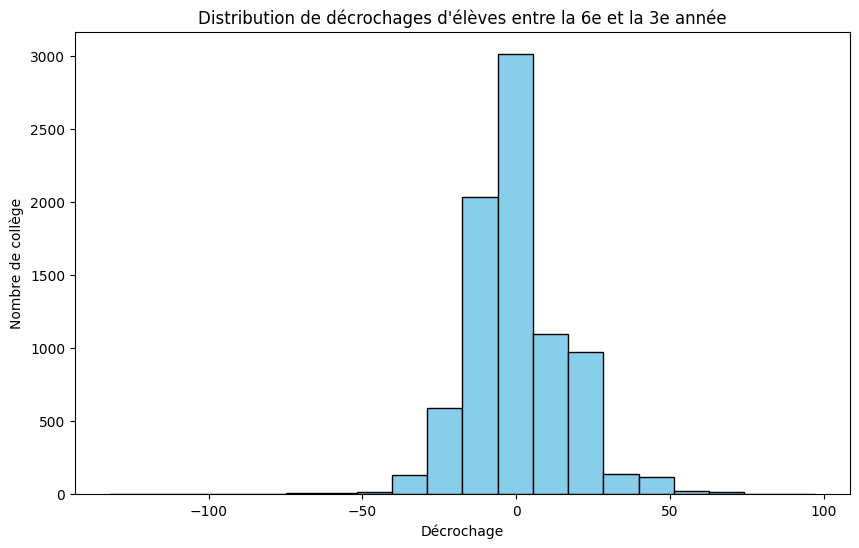

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data_changed['decrochage'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution de décrochages d\'élèves entre la 6e et la 3e année')
plt.xlabel('Décrochage')
plt.ylabel('Nombre de collège')
plt.grid(False)
plt.show()

Regardons de plus près les décrochages

In [ ]:

top_colleges_decrochage = data_changed.nsmallest(10, 'decrochage')[['Numéro du collège', 'decrochage']]
print("Top 10 des collèges avec les réductions les plus élevées :")
print(top_colleges_decrochage)

Top 10 des collèges avec les réductions les plus élevées :
     Numéro du collège  decrochage
5253          0690580F        -132
5316          0692160Y        -103
8040          9730334A         -97
774           0132915Y         -91
6636          0820683X         -71
3002          0440147W         -69
5607          0721408P         -66
4185          0593160P         -65
1924          0311266H         -64
2169          0332723F         -64


On voit que les décrochages ne sont pas les mêmes partout -> on peut garder la disparité des valeurs de décrochages avec un écart-type entre collège de 16 décrochages

In [ ]:
def detect_outliers_iqr(data, column):
    """
    Détecte les valeurs aberrantes dans une colonne d'un DataFrame en utilisant la méthode IQR.

    Parameters:
    data (DataFrame): Le DataFrame contenant les données.
    column (str): Le nom de la colonne pour laquelle détecter les valeurs aberrantes.

    Returns:
    DataFrame: Un DataFrame sans le svaleurs aberrantes
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    data=data.drop(outliers.index)
    print(f"Il y a eu {len(outliers)} valeurs aberrantes supprimés avec la colonne {column}")
    return data

data_changed1=detect_outliers_iqr(data_changed,"decrochage")
data_changed1=detect_outliers_iqr(data_changed1,"Nombre d'élèves total")

Il y a eu 255 valeurs aberrantes supprimés avec la colonne decrochage
Il y a eu 45 valeurs aberrantes supprimés avec la colonne Nombre d'élèves total


In [ ]:
data_changed[["decrochage","Nombre d'élèves total"]].describe()

,decrochage,Nombre d'élèves total
count,8163.000000,8163.000000
mean,0.051084,415.879211
std,15.862099,260.048396
min,-132.000000,4.000000
25%,-10.000000,220.000000
50%,-2.000000,435.000000
75%,8.000000,594.000000
max,97.000000,1868.000000


## Question 2 : Cette tendance a-t'elle un lien avec la taille du collège ? (volume d'étudiants)

Test de Pearson

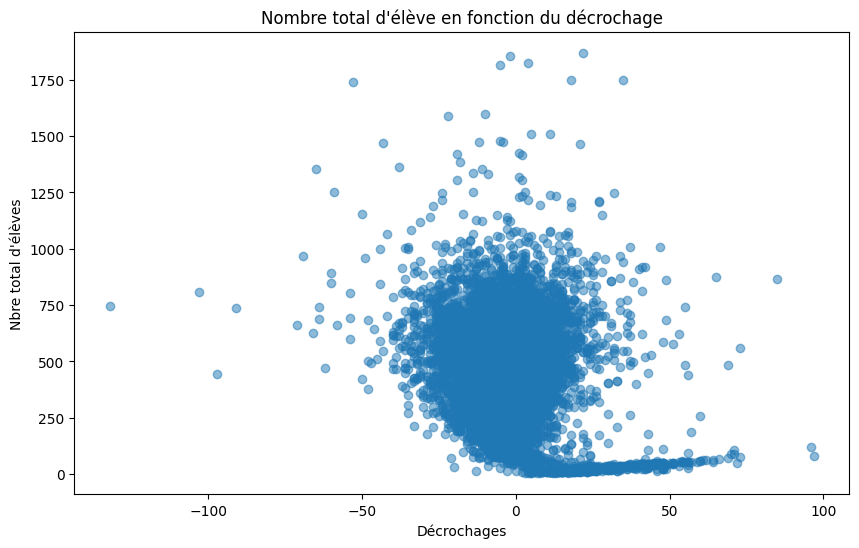

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data_changed['decrochage'], data_changed['Nombre d\'élèves total'], alpha=0.5)
plt.xlabel('Décrochages')
plt.ylabel('Nbre total d\'élèves')
plt.title("Nombre total d'élève en fonction du décrochage")
plt.show()

In [ ]:
coef, p_value = pearsonr(data_changed["Nombre d'élèves total"], data_changed["decrochage"])
print(f"""
      Le coefficient de corrélation de Pearson est {round(coef,2)} \n
      et la p-value est de {round(p_value,3)}
      """)


      Le coefficient de corrélation de Pearson est -0.41 

      et la p-value est de 0.0
      


Vérifions les hypothèses : la distributivité normale des résidus est rejetée

Statistique de Shapiro-Wilk: 0.967799961566925
p-value: 3.284723474389838e-39


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


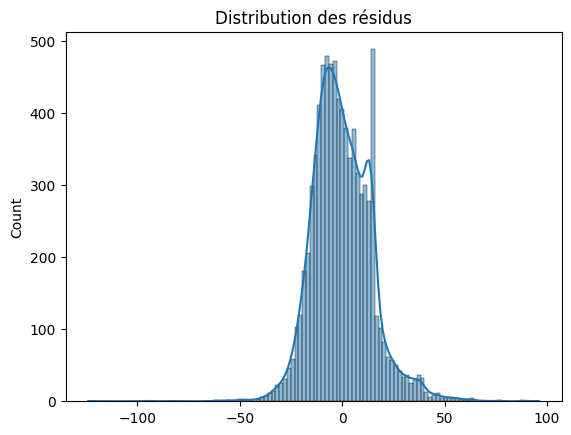

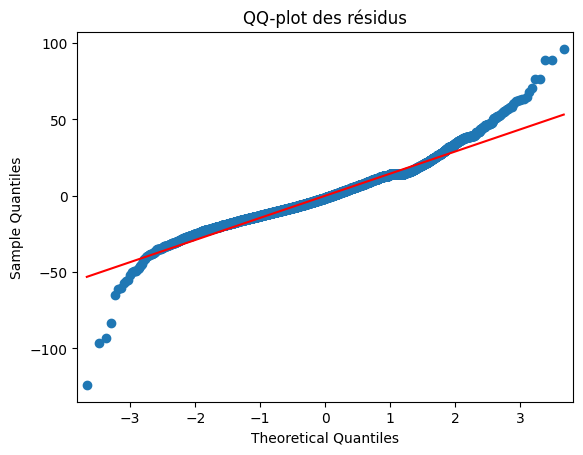

In [ ]:
model = smf.ols('decrochage ~ Q("Nombre d\'élèves total")', data=data_changed).fit()
residus = model.resid

# Test de Shapiro-Wilk
stat, p_value = shapiro(residus)
print('Statistique de Shapiro-Wilk:', stat)
print('p-value:', p_value)

# Histogramme des résidus
sns.histplot(residus, kde=True)
plt.title('Distribution des résidus')
plt.show()

# QQ-plot des résidus
sm.qqplot(residus, line='s')
plt.title('QQ-plot des résidus')
plt.show()

Testons des transformations : cela ne change rien, on rejette toujours la distribution normale des résidus

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistique de Shapiro-Wilk: 0.9825904369354248
p-value: 1.8559421392138536e-30


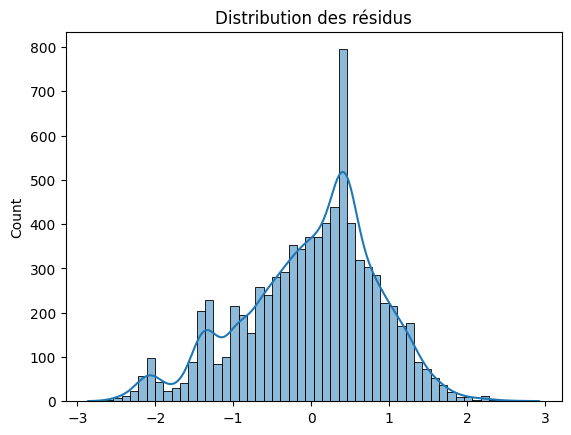

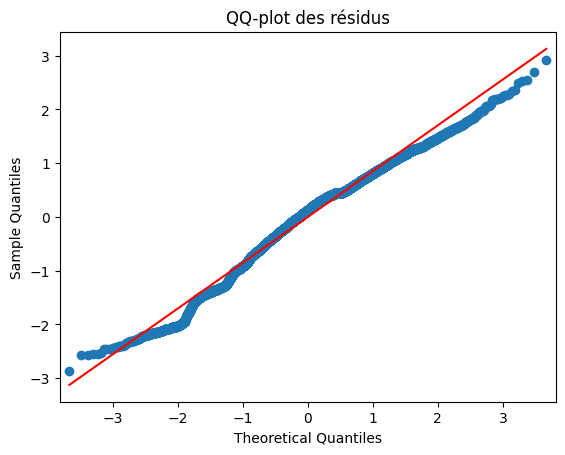

In [ ]:
#Transformation des données
def apply_transformation(data, column, transformation):
    if transformation == 'log':
        return np.log(abs(data[column])+1)
    elif transformation == 'sqrt':
        return np.sqrt(abs(data[column]))

method="log"
data_changed['modifdecrochage']=apply_transformation(data_changed, 'decrochage', transformation=method)
data_changed['modifnbretotal']=apply_transformation(data_changed, 'Nombre d\'élèves total', transformation=method)
## hypothèses de normalité et d'homogénéité des résidus
model = smf.ols('modifdecrochage ~ modifnbretotal', data=data_changed).fit()
residus = model.resid
# Test de Shapiro-Wilk
stat, p_value = shapiro(residus)
print('Statistique de Shapiro-Wilk:', stat)
print('p-value:', p_value)

# Histogramme des résidus
sns.histplot(residus, kde=True)
plt.title('Distribution des résidus')
plt.show()

# QQ-plot des résidus
sm.qqplot(residus, line='s')
plt.title('QQ-plot des résidus')
plt.show()

**Prenons un test non paramétrique plus robuste** :*** Test de Spearman***


---


Nos résultats sont significatifs, cela veut dire qu'il y a un lien entre le décrochage et la taille du collège.
C'est à dire que pour un élève en plus dans le collège, on a 0.35 décrochage en moins



In [ ]:
from scipy.stats import spearmanr
corr, p_value = spearmanr(data_changed['decrochage'], data_changed['Nombre d\'élèves total'])
print("Coefficient de corrélation de Spearman: ", corr)
print("p-value: ", p_value)
if p_value <0.05:
      print(f"Il y a une corrélation significative entre les variables et elle est de {round(corr,2)}")
else: print("Il n'y a pas de preuve suffisante d'une corrélation monotone entre les variables")

Coefficient de corrélation de Spearman:  -0.3466943979982827
p-value:  2.9545428818384446e-229
Il y a une corrélation significative entre les variables et elle est de -0.35


## Question 3 : Est-ce la même conclusion pour les garçons que pour les filles ?

In [ ]:
coef_garcons, p_value_garcons = spearmanr(data_changed['decrochage garçons'], data_changed['decrochage'])
print(f"Corrélation de Spearman pour les garçons : coef={round(coef_garcons,2)}, p_value={round(p_value_garcons,3)}")

coef_filles, p_value_filles = spearmanr(data_changed['decrochage filles'], data_changed['decrochage'])
print(f"Corrélation de Spearman pour les filles : coef={round(coef_filles,2)}, p_value={round(p_value_filles,3)}")

Corrélation de Spearman pour les garçons : coef=0.9, p_value=0.0
Corrélation de Spearman pour les filles : coef=0.82, p_value=0.0


La conclusion n'est pas la même puisque le coefficient est plus important chez les gars que chez les filles. On voit que les 2 distributions sont significativement différentes


In [ ]:
# Trier les valeurs de décrochage garçons et filles
decrochage_garcons = np.sort(data_changed['decrochage garçons'])
decrochage_filles = np.sort(data_changed['decrochage filles'])

# Calculer le coefficient de corrélation de Spearman sur les valeurs triées
coef_garcons, p_value_garcons = spearmanr(decrochage_garcons, data_changed['decrochage'])
print(f"Corrélation de Spearman pour les garçons : coef={round(coef_garcons,2)}, p_value={round(p_value_garcons,3)}")

coef_filles, p_value_filles = spearmanr(decrochage_filles, data_changed['decrochage'])
print(f"Corrélation de Spearman pour les filles : coef={round(coef_filles,2)}, p_value={round(p_value_filles,3)}")



Corrélation de Spearman pour les garçons : coef=0.03, p_value=0.004
Corrélation de Spearman pour les filles : coef=0.03, p_value=0.005


In [ ]:
# Test de Kruskal pour comparer les décrochages entre filles et garçons
statistic, p_value = kruskal(data_changed['decrochage garçons'], data_changed['decrochage filles'])

print("Statistique du test de Kruskal :", statistic)
print("p-value :", p_value)

if p_value < 0.05:
    print("On rejette l'hypothèse nulle : il y a une différence significative entre les décrochages des filles et des garçons.")
else:
    print("On ne rejette pas l'hypothèse nulle : il n'y a pas de preuve suffisante pour conclure à une différence significative entre les décrochages des filles et des garçons.")


Statistique du test de Kruskal : 97.8153149966901
p-value : 4.5928160567642216e-23
On rejette l'hypothèse nulle : il y a une différence significative entre les décrochages des filles et des garçons.


## Question 4 : Est-ce que le constat change en fonction de la région ?

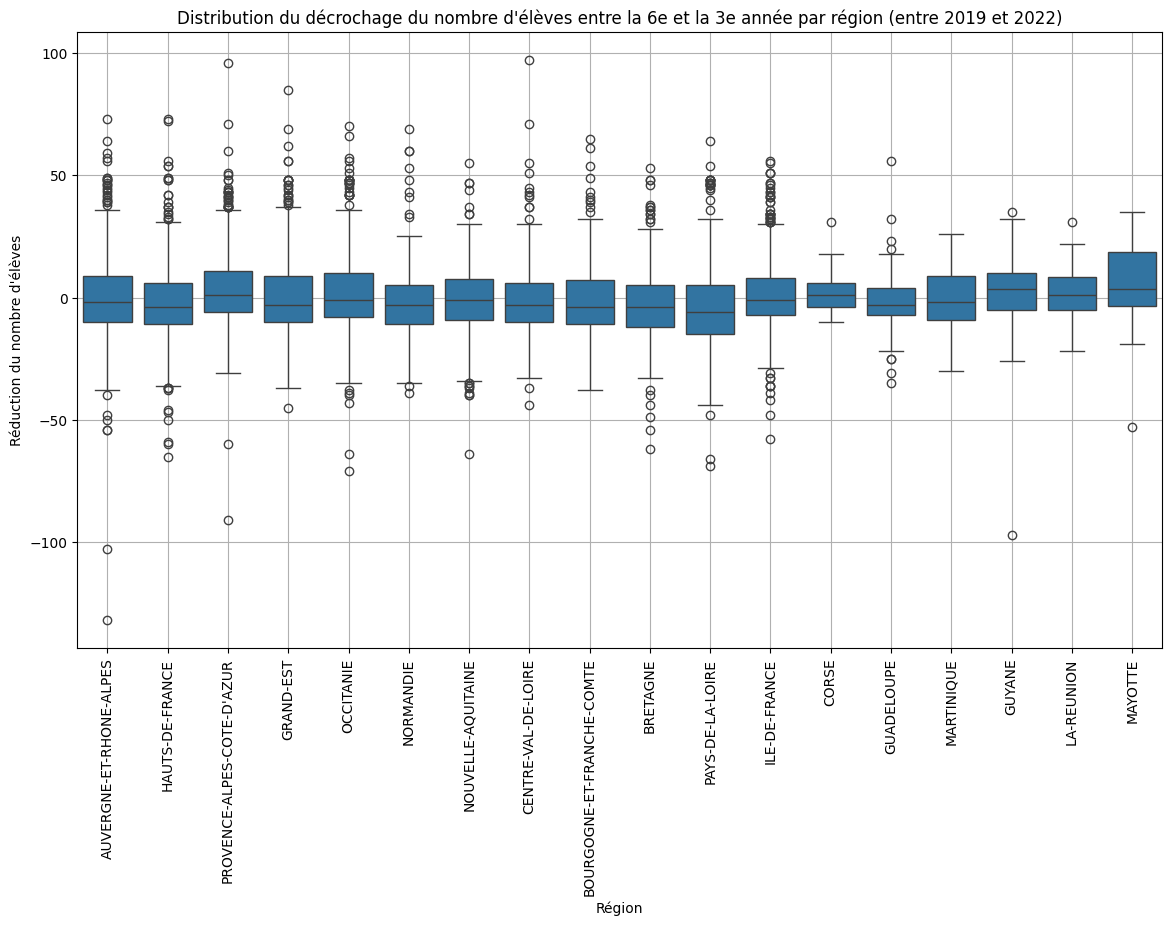

                                mean        std  count
Région                                                
AUVERGNE-ET-RHONE-ALPES     0.126747  17.273290   1002
BOURGOGNE-ET-FRANCHE-COMTE -1.099744  15.900259    391
BRETAGNE                   -2.829837  15.555191    429
CENTRE-VAL-DE-LOIRE        -0.140719  16.555520    334
CORSE                       1.687500   8.448850     32
GRAND-EST                   0.889043  16.003781    721
GUADELOUPE                 -1.596774  14.864921     62
GUYANE                      0.972222  21.718308     36
HAUTS-DE-FRANCE            -1.604621  16.087814    779
ILE-DE-FRANCE               1.109881  13.323380   1265
LA-REUNION                  1.068182   9.732982     88
MARTINIQUE                 -1.245902  11.367579     61
MAYOTTE                     5.954545  19.221707     22
NORMANDIE                  -1.296137  14.982365    466
NOUVELLE-AQUITAINE          0.010610  14.101224    754
OCCITANIE                   1.880342  16.683337    702
PAYS-DE-LA

In [ ]:
# Statistiques de décrochage pour chaque région
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_changed, x='Région', y='decrochage')
plt.title('Distribution du décrochage du nombre d\'élèves entre la 6e et la 3e année par région (entre 2019 et 2022)')
plt.xlabel('Région')
plt.ylabel('Réduction du nombre d\'élèves')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

region_stats = data_changed.groupby('Région')['decrochage'].agg(['mean', 'std', 'count'])
print(region_stats)

Testons la significativité des différences de décrochage entre région


---

Plusieurs choix s'offrent à nous
- Faire le test ANOVA (sous réserve de validation des hypothèses) -> nous avons vu que notre variable de décrochage ne suivait pas l'hypothèse de normalité des résidus
- Utiliser un autre test non-paramétrique comme le test de DUNN, avec la correction de Bonferonni pour voir les tests entre chaque régions

In [ ]:
from statsmodels.stats.multitest import multipletests

region_summaries = data_changed.groupby('Région')['decrochage'].apply(list)
region_summaries=region_summaries.apply(sorted)
# Test de Dune (Kruskal-Wallis) par région
stat, p_value = kruskal(*region_summaries)
print(f"Test de Dune (Kruskal-Wallis) - Statistique : {stat}, p-value: {p_value}")

print("Les distributions des décrochages par région sont significativement différentes")



Test de Dune (Kruskal-Wallis) - Statistique : 147.4216337126249, p-value: 7.815786607433378e-23
Les distributions des décrochages par région sont significativement différentes


In [ ]:
## Rergardons les régions pour qui le décrochage est significativement différent

regions = region_summaries.index.tolist()

# Comparaison de chaque paire de régions avec Kruskal-Wallis
from itertools import combinations
results = []

for region1, region2 in combinations(regions, 2):
    decrochage_region1 = region_summaries[region1]
    decrochage_region2 = region_summaries[region2]

    stat, p_value = kruskal(decrochage_region1, decrochage_region2)
    results.append((region1, region2, stat, p_value))

# Correction de Bonferroni sur les p-values
p_values = [result[3] for result in results]
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

# Afficher les résultats
for i, (region1, region2, stat, p_value) in enumerate(results):
    if adjusted_p_values[i]<0.05:
        print(f"""Comparaison entre {region1} et {region2}: P-value initiale : {p_value}, P-value corrigée (Bonferroni) : {adjusted_p_values[i]}
              """)

NameError: name 'region_summaries' is not defined

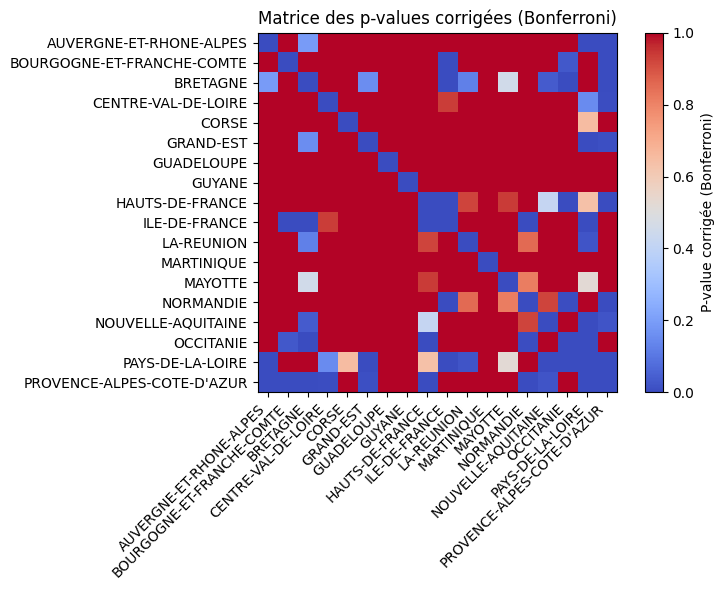

In [ ]:
# Heatmap des p-Values
matrix_size = len(regions)
p_matrix = np.zeros((matrix_size, matrix_size))
for i, (region1, region2, _, _) in enumerate(results):
    idx1 = regions.index(region1)
    idx2 = regions.index(region2)
    p_matrix[idx1, idx2] = adjusted_p_values[i]
    p_matrix[idx2, idx1] = adjusted_p_values[i]  # La matrice est symétrique

# Création de la heatmap avec matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(p_matrix, cmap='coolwarm', vmin=0, vmax=1)

plt.colorbar(label='P-value corrigée (Bonferroni)')
plt.xticks(range(matrix_size), regions, rotation=45, ha='right')
plt.yticks(range(matrix_size), regions)
plt.title('Matrice des p-values corrigées (Bonferroni)')
plt.tight_layout()
plt.show()

## Question 5 : Y-a-t'il un lien avec le fait d'être en collège public ou privé ?

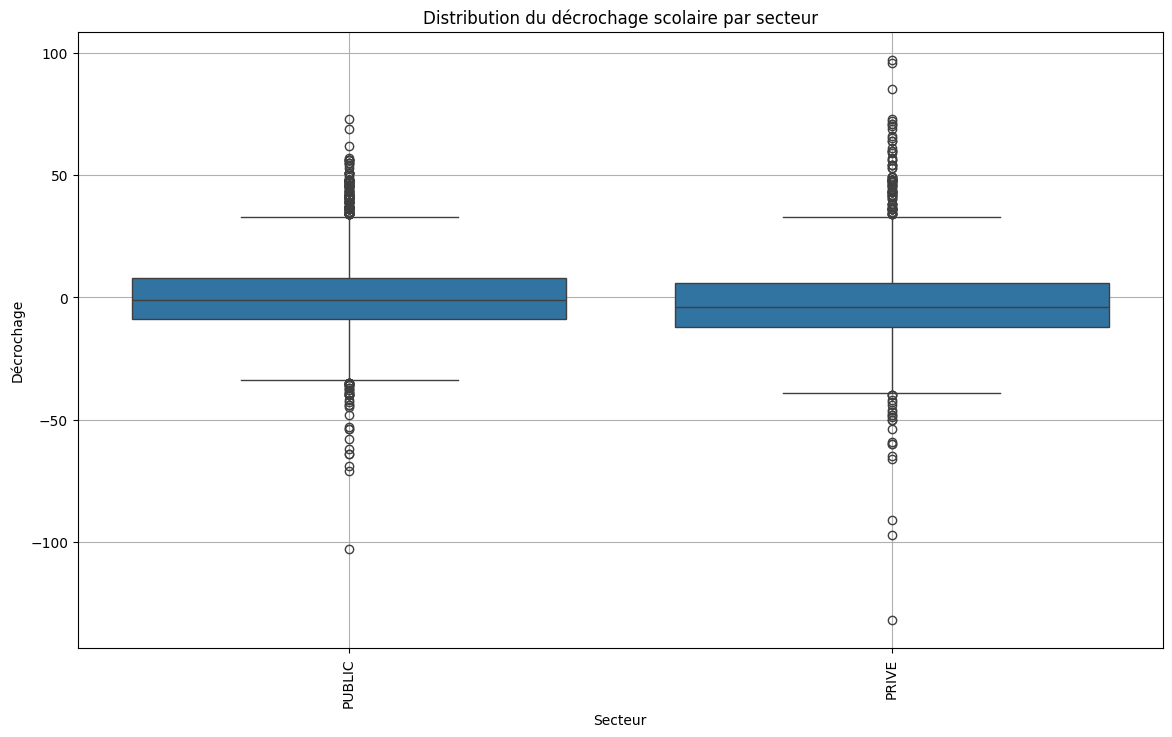

In [ ]:
# Graphique pour visualiser les différences
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_changed, x='Secteur', y='decrochage')
plt.title('Distribution du décrochage scolaire par secteur')
plt.xlabel('Secteur')
plt.ylabel('Décrochage')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [ ]:
secteur_summaries = data_changed.groupby('Secteur')['decrochage'].apply(list)
secteur_summaries=secteur_summaries.apply(sorted)
# Test de Dune (Kruskal-Wallis) par région
stat, p_value = kruskal(*secteur_summaries)
print(f"Test de Dune (Kruskal-Wallis) - Statistique : {stat}, p-value: {p_value}")

print("""Les distributions des décrochages par secteur sont significativement différentes, donc il y a un lien entre le secteur et le décrochage
""")


Test de Dune (Kruskal-Wallis) - Statistique : 48.55201383310481, p-value: 3.2164386215511064e-12
Les distributions des décrochages par secteur sont significativement différentes, donc il y a un lien entre le secteur et le décrochage

